# DeCRED paper plots generation

In [1]:
%cd ../..

/Users/alexanderpolok/PycharmProjects/IS24_DeCRED


In [2]:
!pip install SciencePlots
!pip install matplotlib
!pip install latex
!pip install numpy
!pip install confidence_intervals

In [3]:
from confidence_intervals import get_bootstrap_indices, get_conf_int

import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scienceplots

fs = 12  # fontsize
plt.style.use(['science'])
plt.figure(1, figsize=(10, 5))


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [4]:
def create_figure(data, num_systems, num_systems_per_group, name, range=(0, 100)):
    figsize = (14, 4)

    plt.style.use(['science'])
    fig, ax = plt.subplots(num=2, figsize=figsize)

    # The groups should be the same for all labels
    allgroups = np.unique(np.concatenate([list(lvalues.keys()) for lvalues in data.values()]))

    barWidth = 1 / (len(data) + 1)

    group_starts = np.arange(len(allgroups))
    is_even_number_of_systems = (num_systems % 2) == 0

    for j, (lname, lvalues) in enumerate(data.items()):
        lname = lname.split("_")[0]
        xvalues = group_starts + barWidth * j

        # Plot the bars for the given top label across all groups
        yvalues = [lvalues[group][0] if group in lvalues else 0 for group in allgroups]
        a = 1 - (j // num_systems_per_group) * (0.35)  # intensity
        c = f"C{j % num_systems_per_group if j< num_systems_per_group or is_even_number_of_systems else  (j +1) % num_systems_per_group}"

        ax.bar(xvalues, yvalues, color=c, width=barWidth, label=lname, alpha=a)

        # Now plot a line on top of the bar to show the confidence interval
        for k, group in enumerate(allgroups):
            ci = lvalues[group][1]
            ax.plot(xvalues[k] * np.ones(2), ci, 'k')

    ax.set_xticks(group_starts + barWidth * (len(data) - 1) / 2, allgroups, fontsize=fs)
    # Get the labels and their handles
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # If the number of labels is odd, add an empty label to the second column
    if not is_even_number_of_systems:
        # Create two columns: one with all elements and one shifted
        col1 = labels[:len(labels)//2 + 1]   # First column
        col2 = [""] + labels[len(labels)//2 + 1:]  # Second column (shifted)
        
        # Reorganize the labels and handles to fit two columns
        new_labels = col1 + col2
        new_handles = handles[:len(labels)//2 + 1] +  [matplotlib.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                 visible=False)] + handles[len(labels)//2 + 1:]
    
        ax.legend(new_handles, new_labels, fontsize=fs, ncols=2)
    
    else:
        # If even, just display regularly in two columns
        ax.legend(handles, labels, fontsize=fs, ncols=2)

    ax.grid(linestyle='--', alpha=0.5)
    plt.ylim(*range)
    plt.xticks(rotation=0)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False)         # ticks along the top edge are off
    plt.savefig(name, dpi=300)

In [5]:
def paired_bootstrap(data1, data2, num_bootstraps, sample_ratio):
    n = len(data1["wers"])
    assert n == len(data2["wers"])
    wins = [0, 0, 0]
    sys1_scores = []
    sys2_scores = []
    ids = np.arange(n)
    lens = 0
    for i in range(num_bootstraps):
        idx = np.random.choice(ids, int(len(ids) * sample_ratio), replace=True)
        data1_len = data1["lens"][idx].sum()
        data2_len = data2["lens"][idx].sum()
        sys1_score = data1["wers"][idx].sum()
        sys2_score = data2["wers"][idx].sum()
        lens += data1_len
        if sys1_score > sys2_score:
            wins[1] += 1
        elif sys1_score < sys2_score:
            wins[0] += 1
        else:
            wins[2] += 1
        sys1_scores.append(sys1_score)
        sys2_scores.append(sys2_score)
    wins = [x / float(num_bootstraps) for x in wins]
    print('Win ratio: sys1=%.3f, sys2=%.3f, tie=%.3f' % (wins[0], wins[1], wins[2]))
    if wins[0] > wins[1]:
        print('(sys1 is superior with p value p=%.3f)\n' % (1 - wins[0]))
    elif wins[1] > wins[0]:
        print('(sys2 is superior with p value p=%.3f)\n' % (1 - wins[1]))

    # Print system stats
    sys1_scores.sort()
    sys2_scores.sort()
    print('sys1 mean=%.3f, median=%.3f, 95%% confidence interval=[%.3f, %.3f]' %
          (np.sum(sys1_scores) / lens, np.median(sys1_scores), sys1_scores[int(num_bootstraps * 0.025)],
           sys1_scores[int(num_bootstraps * 0.975)]))
    print('sys2 mean=%.3f, median=%.3f, 95%% confidence interval=[%.3f, %.3f]' %
          (np.sum(sys2_scores) / lens, np.median(sys2_scores), sys2_scores[int(num_bootstraps * 0.025)],
           sys2_scores[int(num_bootstraps * 0.975)]))

In [6]:
def extract_errors(filename, test_sets_to_skip=None):
    test_sets = sorted(glob.glob(filename + '/*.utt'))
    per_set_wers = []
    per_set_lens = []
    set_names = []
    for index, test_set in enumerate(test_sets):
        should_skip = False
        if test_sets_to_skip is not None:
            for skip in test_sets_to_skip:
                if skip in test_set:
                    should_skip = True
        if should_skip:
            continue
        set_name = re.search(r".*predictions_(.*)_hyp.*", test_set).group(1)
        with open(test_set, 'r') as file:
            content = file.read()

        error_pattern = r'Errors\s+=\s+\d+\.\d+\%\s+(\d+)\s+\(\s*\d+\s*\)'
        len_patttern = r'Ref. words\s+=\s+(\d+)\s+\(\s*\d+\s*\)'
        errors = re.findall(error_pattern, content)
        lens = re.findall(len_patttern, content)

        errors = np.array([int(error) for error in errors])
        lens = np.array([int(l) for l in lens])
        per_set_wers.append(errors)
        per_set_lens.append(lens)
        set_names.append(set_name)

    return per_set_wers, per_set_lens, None, set_names

In [7]:
def compute_confidence_intervals(decisions, conditions, set_names, alpha=10, num_bootstraps=10000):
    data = {}
    for sys, dec in decisions.items():
        data[sys] = {}
        for index, set in enumerate(set_names):
            num_samples = len(dec[0][index])
            metric_values = []
            for nb in np.arange(num_bootstraps):
                indices = get_bootstrap_indices(num_samples, conditions=conditions, random_state=nb)
                errors = dec[0][index][indices]
                local_lens = dec[1][index][indices]
                metric_values.append(np.sum(errors) / np.sum(local_lens) * 100)
            # val_no_cond = evaluate_with_conf_int(dec, metric, labels, None, num_bootstraps=num_bootstraps, alpha=alpha)
            data[sys][set] = (np.sum(dec[0][index]) / np.sum(dec[1][index]) * 100, get_conf_int(metric_values, alpha))
        data[sys]["macro avg."] = (np.average([data[sys][set][0] for set in set_names]), (0, 0))
    return data


## Create comparison between DeCRED and ED on multiple test sets

In [8]:
decred_wer_tuned, decred_tuned_len, conditions, set_names = extract_errors(
    'predictions/greedy_ctc/finetune_mixing_mechanism_linear_v2_ctc',
    test_sets_to_skip=["fleurs", "gigaspeech", "ami"])

decred_wer, decred_len, conditions, set_names = extract_errors(
    'predictions/greedy_ctc/english_model_medium_regularized_greedy_ctc',
    test_sets_to_skip=["fleurs", "gigaspeech", "ami"])

ed_wer, ed_len, conditions, set_names = extract_errors(
    'predictions/greedy_ctc/english_model_medium_greedy_ctc',
    test_sets_to_skip=["fleurs", "gigaspeech", "ami"])

decred_wer_small_tuned, decred_tuned_len_small, conditions, set_names = extract_errors(
    'predictions/greedy_ctc/english_model_small_tuned_greedy_ctc',
    test_sets_to_skip=["fleurs", "gigaspeech", "ami"])

decred_wer_small, decred_len_small, conditions, set_names = extract_errors(
    'predictions/greedy_ctc/english_model_small_regularized_greedy_ctc',
    test_sets_to_skip=["fleurs", "gigaspeech", "ami"])

ed_wer_small, ed_len_small, conditions, set_names = extract_errors(
    'predictions/greedy_ctc/english_model_small_greedy_ctc',
    test_sets_to_skip=["fleurs", "gigaspeech", "ami"])

set_names = ['CV-13', 'SB eval2000', 'LS clean', 'LS other', 'TEDLIUM3', 'VoxPopuli', 'WSJ']

decisions = {r"$\text{DeCRED base}^{(6)}$": (decred_wer_tuned, decred_tuned_len),
             r"$\text{DeCRED base}^{(4)}$": (decred_wer, decred_len),
             r"$\text{ED base}^{(4)}$": (ed_wer, ed_len),
             r"$\text{DeCRED small}^{(6)}$": (decred_wer_small_tuned, decred_tuned_len_small),
             r"$\text{DeCRED small}^{(4)}$": (decred_wer_small, decred_len_small),
             r"$\text{ED small}^{(4)}$": (ed_wer_small, ed_len_small),
             }

In [9]:
alpha = 10
num_bootstraps = int(50 / alpha * 100)
data = compute_confidence_intervals(decisions, conditions, set_names, alpha=alpha, num_bootstraps=num_bootstraps)
data

{'$\\text{DeCRED base}^{(6)}$': {'CV-13': (12.182917864926557,
   (11.846157886064061, 12.549541742863378)),
  'SB eval2000': (9.111958275837875, (8.690638727577234, 9.512992522454939)),
  'LS clean': (2.347594893745404, (2.1867530524655265, 2.5166121248672426)),
  'LS other': (5.54862371445856, (5.293159565439814, 5.814349579641505)),
  'TEDLIUM3': (5.690192743764173, (5.319194719888107, 6.101551969762331)),
  'VoxPopuli': (7.257259528130672, (6.764109050148738, 7.947978829510537)),
  'WSJ': (1.511917467093561, (1.1730322311994863, 1.8379544248270951)),
  'macro avg.': (6.235780641136686, (0, 0))},
 '$\\text{DeCRED base}^{(4)}$': {'CV-13': (12.02486346373326,
   (11.763115052730939, 12.291830080580054)),
  'SB eval2000': (9.356383600046723, (8.947894636414393, 9.745425148285484)),
  'LS clean': (2.3721079327965606, (2.1894975022140057, 2.538124631250625)),
  'LS other': (5.522156684815487, (5.273042968207207, 5.747029554105351)),
  'TEDLIUM3': (6.349206349206349, (5.943955936560857, 6

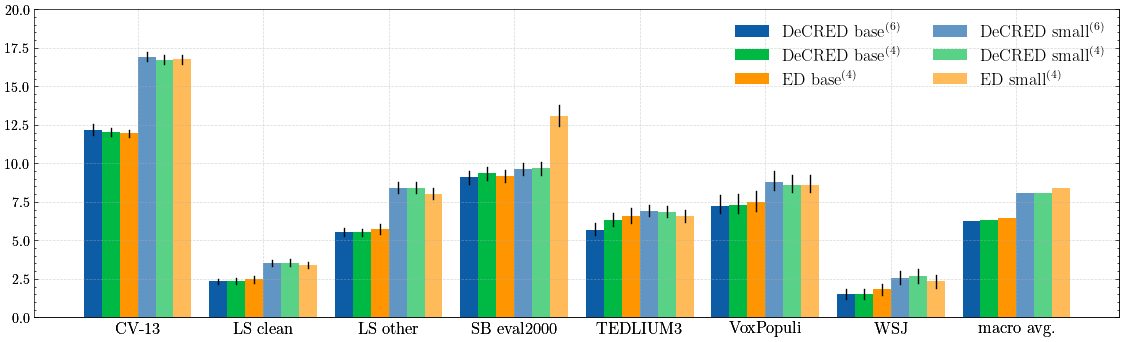

In [10]:
create_figure(data, name="figures/ed_vs_decred.pdf", range=(0, 20), num_systems=6, num_systems_per_group=3)
create_figure(data, name="figures/ed_vs_decred.png", range=(0, 20), num_systems=6, num_systems_per_group=3)

# Compute the paired bootstrap test

In [11]:
alpha = 10
num_bootstraps = 10000

In [12]:
decred_base = {"wers": np.concatenate(decred_wer), "lens": np.concatenate(decred_len)}
decred_base_tuned = {"wers": np.concatenate(decred_wer_tuned), "lens": np.concatenate(decred_tuned_len)}
ed_base = {"wers": np.concatenate(ed_wer), "lens": np.concatenate(ed_len)}
paired_bootstrap(decred_base, ed_base, num_bootstraps, 0.5)
paired_bootstrap(decred_base_tuned, ed_base, num_bootstraps, 0.5)

Win ratio: sys1=0.662, sys2=0.335, tie=0.003
(sys1 is superior with p value p=0.338)

sys1 mean=0.084, median=15949.000, 95% confidence interval=[15472.000, 16465.000]
sys2 mean=0.084, median=16004.000, 95% confidence interval=[15526.000, 16535.000]
Win ratio: sys1=0.705, sys2=0.293, tie=0.002
(sys1 is superior with p value p=0.295)

sys1 mean=0.083, median=15914.000, 95% confidence interval=[15414.000, 16528.000]
sys2 mean=0.084, median=16006.000, 95% confidence interval=[15527.000, 16536.000]


In [13]:
for i, test_set in enumerate(set_names):
    decred = {"wers": np.array(decred_wer[i]), "lens": np.array(decred_len[i])}
    decred_tuned = {"wers": np.array(decred_wer_tuned[i]), "lens": np.array(decred_tuned_len[i])}
    ed = {"wers": np.array(ed_wer[i]), "lens": np.array(ed_len[i])}
    print(test_set)
    print("DeCRED base")
    paired_bootstrap(decred, ed, num_bootstraps, 0.5)
    print("\nDeCRED tuned")
    paired_bootstrap(decred_tuned, ed, num_bootstraps, 0.5)
    print("-" * 50)

CV-13
DeCRED base
Win ratio: sys1=0.268, sys2=0.728, tie=0.003
(sys2 is superior with p value p=0.272)

sys1 mean=0.120, median=9317.000, 95% confidence interval=[8993.000, 9690.000]
sys2 mean=0.119, median=9259.000, 95% confidence interval=[8954.000, 9573.000]

DeCRED tuned
Win ratio: sys1=0.078, sys2=0.920, tie=0.001
(sys2 is superior with p value p=0.080)

sys1 mean=0.122, median=9427.000, 95% confidence interval=[9059.000, 9942.000]
sys2 mean=0.119, median=9263.000, 95% confidence interval=[8950.000, 9580.000]
--------------------------------------------------
SB eval2000
DeCRED base
Win ratio: sys1=0.195, sys2=0.799, tie=0.006
(sys2 is superior with p value p=0.201)

sys1 mean=0.094, median=2002.000, 95% confidence interval=[1855.000, 2156.000]
sys2 mean=0.092, median=1959.000, 95% confidence interval=[1816.000, 2110.000]

DeCRED tuned
Win ratio: sys1=0.584, sys2=0.408, tie=0.008
(sys1 is superior with p value p=0.416)

sys1 mean=0.091, median=1944.000, 95% confidence interval=[18

## Comparison between DeCRED and OWSM and Whisper

In [14]:
decred_wer, decred_len, conditions, set_names = extract_errors(
    'predictions/greedy/english_model_medium_regularized_greedy')

whisper_normalised_wer, whisper_normalised_len, conditions, set_names = extract_errors(
    'predictions/greedy/decode_whisper_medium_greedy',
    test_sets_to_skip=["fleurs", "gigaspeech", "ami"])
whisper_wer, whisper_len, conditions, set_names = extract_errors(
    'predictions/greedy/whisper_medium_regularized_decode',
    test_sets_to_skip=["fleurs", "gigaspeech", "ami"])
decred_normalised_wer, decred_normalised_len, conditions, set_names = extract_errors(
    'predictions/greedy/finetune_mixing_mechanism_linear_v2',
    test_sets_to_skip=["fleurs", "gigaspeech", "ami"])

decred_wer_tuned, decred_tuned_len, conditions, set_names = extract_errors(
    'predictions/greedy/finetune_mixing_mechanism_linear_v2',
    test_sets_to_skip=["fleurs", "gigaspeech", "ami"])

owsm_normalised_wer, owsm_normalised_len, conditions, set_names = extract_errors(
    'predictions/greedy/decode_owsm_v3_greedy',
    test_sets_to_skip=["fleurs", "gigaspeech", "ami"])

owsm_wer, owsm_len, conditions, set_names = extract_errors(
    'predictions/greedy/decode_owsm_v3_greedy_original',
    test_sets_to_skip=["fleurs", "gigaspeech", "ami"])

owsm_wer = [dataset - 1 for dataset in
            owsm_wer]  # This is temporal fix due to [ENG][ASR][NOTIMESTAMPS] -> ENGASRNOTIMESTAMPS tokens that were incorrectly normalised 

decisions = {
    r"$\text{DeCRED base}^{(6)}$": (decred_wer_tuned, decred_tuned_len),
    r"$\text{DeCRED base}^{(4)}$": (decred_normalised_wer, decred_normalised_len),
    "Whisper medium": (whisper_normalised_wer, whisper_normalised_len),
    "OWSM v3": (owsm_normalised_wer, owsm_normalised_len),
    r"$\text{DeCRED base}^{(4)}~\text{unnormalised}$": (decred_wer, decred_len),
    "Whisper medium unnormalised": (whisper_wer, whisper_len),
    "OWSM v3 unnormalised": (owsm_wer, owsm_len)
}

set_names = ['CV-13', 'SB eval2000', 'LS clean', 'LS other', 'TEDLIUM3', 'VoxPopuli', 'WSJ']

In [15]:
alpha = 10
num_bootstraps = int(50 / alpha * 100)
data = compute_confidence_intervals(decisions, conditions, set_names, alpha=alpha, num_bootstraps=num_bootstraps)
data

{'$\\text{DeCRED base}^{(6)}$': {'CV-13': (12.143584849696296,
   (11.834258234330239, 12.494823574378737)),
  'SB eval2000': (10.364270172893807, (8.853078995880853, 12.714877071177733)),
  'LS clean': (2.453189523504233, (2.270972950228895, 2.6628353963197595)),
  'LS other': (5.62046279491833, (5.354940994038836, 5.860931321362856)),
  'TEDLIUM3': (6.257086167800454, (5.84107969471914, 6.7290344886367555)),
  'VoxPopuli': (7.3321234119782215, (6.881982842476852, 7.977952567845478)),
  'WSJ': (1.3340448239060834, (1.0653158875510698, 1.640002265413988)),
  'macro avg.': (6.50068024924249, (0, 0))},
 '$\\text{DeCRED base}^{(4)}$': {'CV-13': (12.143584849696296,
   (11.834258234330239, 12.494823574378737)),
  'SB eval2000': (10.364270172893807, (8.853078995880853, 12.714877071177733)),
  'LS clean': (2.453189523504233, (2.270972950228895, 2.6628353963197595)),
  'LS other': (5.62046279491833, (5.354940994038836, 5.860931321362856)),
  'TEDLIUM3': (6.257086167800454, (5.84107969471914, 

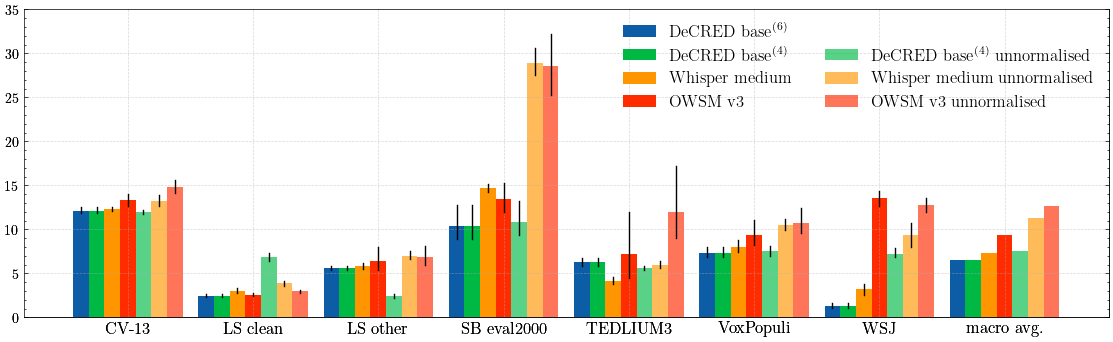

In [16]:
create_figure(data, name="figures/decred_whisper_owsm.pdf", num_systems=7, num_systems_per_group=4, range=(0, 35))
create_figure(data, name="figures/decred_whisper_owsm.png", num_systems=7, num_systems_per_group=4, range=(0, 35))

## WER vs. slowdown

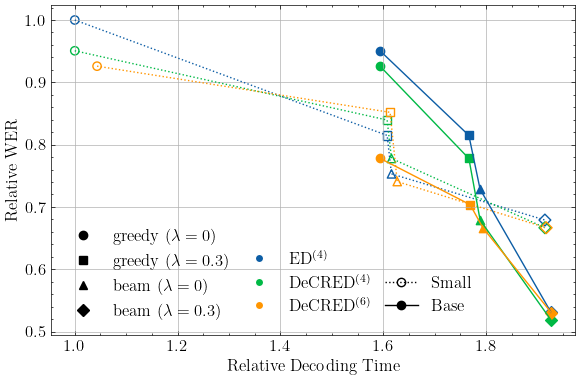

In [17]:
# Provided data (including additional data)
data_small = [
    ['ED$^{(4)}$', "greedy ($\lambda=0$)", 0.0, 0.0],
    ['ED$^{(4)}$', "greedy ($\lambda=0.3)$", 0.1851851851851852, 0.6075079345885781],
    ['ED$^{(4)}$', "beam ($\lambda=0$)", 0.2469135802469136, 0.6159825544400591],
    ['ED$^{(4)}$', "beam ($\lambda=0.3$)", 0.32098765432098764, 0.9143455654475978],
    ['DeCRED$^{(4)}$', "greedy ($\lambda=0$)", 0.04938271604938265, 0.0],
    ['DeCRED$^{(4)}$', "greedy ($\lambda=0.3)$", 0.16049382716049382, 0.6075079345885781],
    ['DeCRED$^{(4)}$', "beam ($\lambda=0$)", 0.2222222222222222, 0.6159825544400591],
    ['DeCRED$^{(4)}$', "beam ($\lambda=0.3$)", 0.33333333333333326, 0.9143455654475978],
    ['DeCRED$^{(6)}$', "greedy ($\lambda=0$)", 0.07407407407407403, 0.04334220576884247],
    ['DeCRED$^{(6)}$', "greedy ($\lambda=0.3)$", 0.14814814814814806, 0.6132373299956767],
    ['DeCRED$^{(6)}$', "beam ($\lambda=0$)", 0.25925925925925924, 0.6271363679314989],
    ['DeCRED$^{(6)}$', "beam ($\lambda=0.3$)", 0.33333333333333326, 0.9168763058404015],
]
models_small = [
    'ED$^{(4)}$', 'DeCRED$^{(4)}$', r'DeCRED$^{(6)}$',
]

# Provided data (including additional data)
data_base = [
    ['ED$^{(4)}$', "greedy ($\lambda=0$)", 0.04938271604938265, 0.5936907834210328],
    ['ED$^{(4)}$', "greedy ($\lambda=0.3)$", 0.1851851851851852, 0.7664729001222124],
    ['ED$^{(4)}$', "beam ($\lambda=0$)", 0.27160493827160487, 0.7883367743869902],
    ['ED$^{(4)}$', "beam ($\lambda=0.3$)", 0.4691358024691358, 0.926237998124568],
    ['DeCRED$^{(4)}$', "greedy ($\lambda=0$)", 0.07407407407407403, 0.5936907834210328],
    ['DeCRED$^{(4)}$', "greedy ($\lambda=0.3)$", 0.2222222222222222, 0.7664729001222124],
    ['DeCRED$^{(4)}$', "beam ($\lambda=0$)", 0.32098765432098764, 0.7883367743869902],
    ['DeCRED$^{(4)}$', "beam ($\lambda=0.3$)", 0.48148148148148145, 0.926237998124568],
    ['DeCRED$^{(6)}$', "greedy ($\lambda=0$)", 0.2222222222222222, 0.5942796682046714],
    ['DeCRED$^{(6)}$', "greedy ($\lambda=0.3)$", 0.2962962962962962, 0.768929824575187],
    ['DeCRED$^{(6)}$', "beam ($\lambda=0$)", 0.33333333333333326, 0.7936160604057941],
    ['DeCRED$^{(6)}$', "beam ($\lambda=0.3$)", 0.469358024691358, 0.9265720551207585]
]
models_base = [
    'ED$^{(4)}$', 'DeCRED$^{(4)}$', r'DeCRED$^{(6)}$',
]

# Define markers for each decoding strategy
marker_dict = {
    "greedy ($\lambda=0$)": "o",
    "greedy ($\lambda=0.3)$": "s",
    "beam ($\lambda=0$)": "^",
    "beam ($\lambda=0.3$)": "D"
}

# Define colors for each model
color_dict = {
    "ED$^{(4)}$": "C0",
    "DeCRED$^{(4)}$": "C1",
    "DeCRED$^{(6)}$": "C2",
}


def adjusted_slowdown(data):
    new_data = data[:]
    for i in range(len(new_data)):
        new_data[i][2] = (1.0 - new_data[i][2]) #  * 8.1 # absolute WERs are a bit more straightfoward
        new_data[i][3] += 1.0

    return new_data


def plot_speedup(axis, data, model_names, line_style='-', marker_style='full', face_colors=None):
    data_np = np.array(data)

    # Extract columns
    models = data_np[:, 0]
    strategies = data_np[:, 1]
    wer_reduction = data_np[:, 2].astype(float)
    relative_slowdown = data_np[:, 3].astype(float)

    for i in range(len(models)):
        axis.scatter(
            relative_slowdown[i], wer_reduction[i],
            color=color_dict[models[i]],
            marker=marker_dict[strategies[i]],
            facecolors=face_colors,
            label=f"{models[i]}, {strategies[i]}"
        )

    for model_name in model_names:
        xs = [rs for model, rs in zip(models, relative_slowdown) if model == model_name]
        ys = [rwerr for model, rwerr in zip(models, wer_reduction) if model == model_name]
        axis.plot(xs, ys, color=color_dict[model_name], linestyle=line_style)

    axis.set_xlabel('Relative Decoding Time', fontsize=fs)
    axis.set_ylabel('Relative WER', fontsize=fs)


def plot_legend(axis):
    def put_dummy():
        handles.append(plt.Line2D([0], [0], marker='.', fillstyle='none', color='w', alpha=0.0, linestyle='None'))
        labels.append('')

    handles = []
    labels = []

    # ------- decoding strategy - no dummies here, these are the most numerous and thus define the col length -----
    for strategy in marker_dict:
        handles.append(plt.Line2D([0], [0], marker=marker_dict[strategy], color='k', linestyle='None'))
        labels.append(strategy)

    # ------- ED / DeCRED -----
    put_dummy()
    for model in color_dict:
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[model]))
        labels.append(model)



    # ------- model sizes -----
    put_dummy()
    put_dummy()

    handles.append(plt.Line2D([0], [0], marker='o', fillstyle='none', color='k', linestyle='dotted'))
    labels.append('Small')

    handles.append(plt.Line2D([0], [0], marker='o', fillstyle='full', color='k', linestyle='-'))
    labels.append('Base')



    def reorg(orig):
        return orig
        # return np.asarray(orig).reshape([3,4]).T.flatten().tolist()

    axis.legend(reorg(handles), reorg(labels), loc='best', ncols=3, fontsize=fs, columnspacing=0.8)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
plot_speedup(ax1, adjusted_slowdown(data_small), models_small, 'dotted', face_colors='None')
plot_speedup(ax1, adjusted_slowdown(data_base), models_base, '-')

plot_legend(ax1)

plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)
ax1.grid(True)

plt.tight_layout()
plt.savefig("figures/slowdown_wer.pdf", dpi=300)